<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/02b_deep_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [1]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# DeepDenoiser

This tutorial shows how to apply DeepDenoiser (Zhu et al 2019) and how using deep denoiser can significantly improve picking models.

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [2]:
import seisbench.models as sbm

from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt

We demonstrate DeepDenoiser using waveforms from Chile, hours after the Mw=8.1 Iquique earthquake in April 2014. Due to the close proximity to the large shock, there are plenty of overlapping aftershocks in this time period.

**Note:** To play around with other waveforms, simply modify the cell below to (down)load your waveforms.

In [3]:
client = Client("GFZ")

t = UTCDateTime("2014/04/02 05:47:50")
stream = client.get_waveforms(network="CX", station="PB01", location="*", channel="HH?", starttime=t, endtime=t+200)

Let's first visualize the 200 s of waveforms. Apparently, we see the coda of a larger event. It is not really possible to identify any small events within the window.

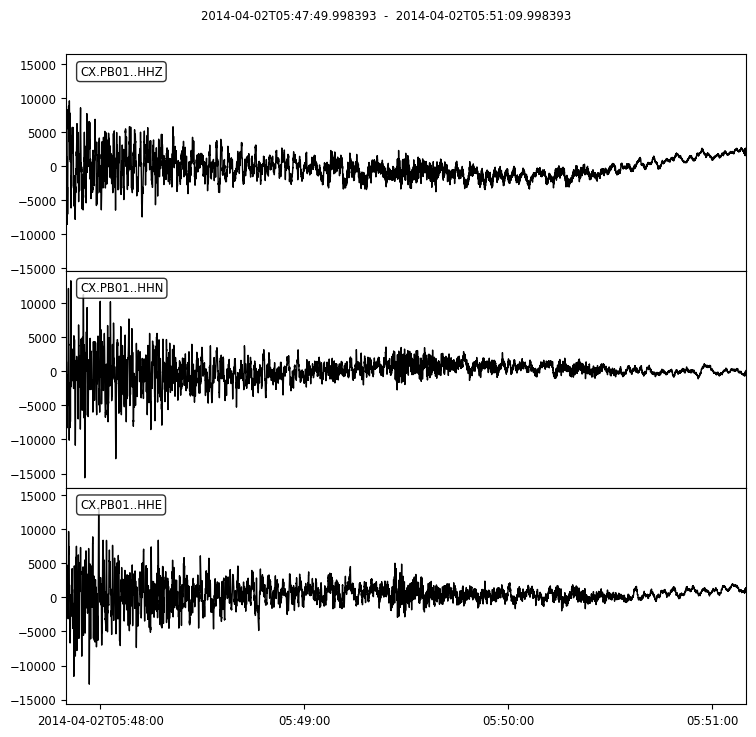

In [4]:
stream.plot();

We load the DeepDenoiser model through SeisBench, using the (converted) original weights from Zhu et al (2019).

In [5]:
model = sbm.DeepDenoiser.from_pretrained("original")

For more information on the model architecture, along with the original training schema to get the trained model weights, see:

In [6]:
model.citation

'Zhu, W., Mousavi, S. M., & Beroza, G. C. (2019). Seismic signal denoising and decomposition using deep neural networks. IEEE Transactions on Geoscience and Remote Sensing, 57.11(2019), 9476 - 9488. https://doi.org/10.1109/TGRS.2019.2926772'

As with the picking models, we can use the ```annotate``` function to apply DeepDenoiser to a stream.

In [7]:
annotations = model.annotate(stream)

Now let's visualize the denoised predictions. In contrast to the original data, we can immediatly spot several candidates for earthquakes.

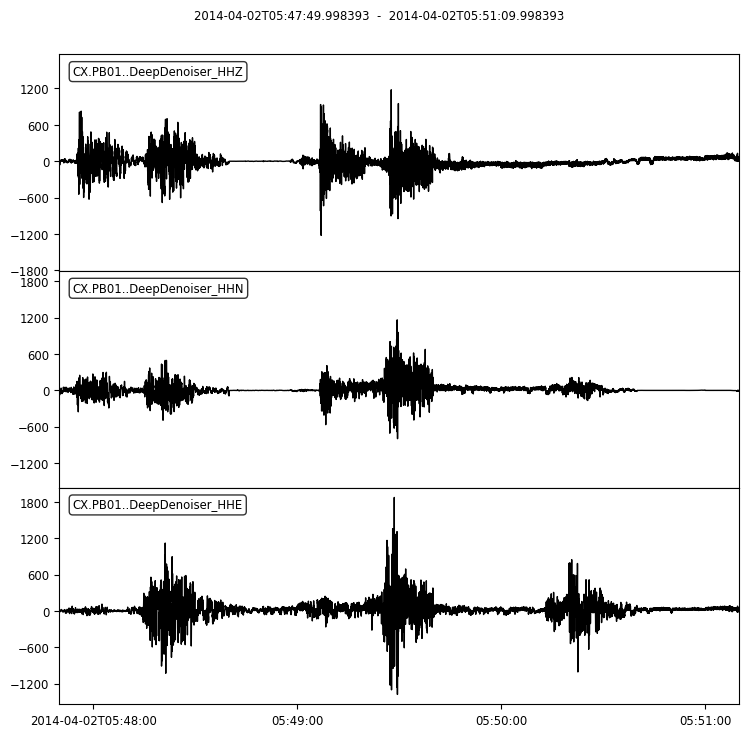

In [8]:
annotations.plot();

## Influence of denoising on picking

We have seen that denoising makes it considerably easier to identify earthquakes visually. But how about coupling denoising with an automatic picking algorithm? Below we use EQTransformer to annotate the original stream (top) and then the denoised stream (bottom).

In [9]:
picker = sbm.EQTransformer.from_pretrained("instance")

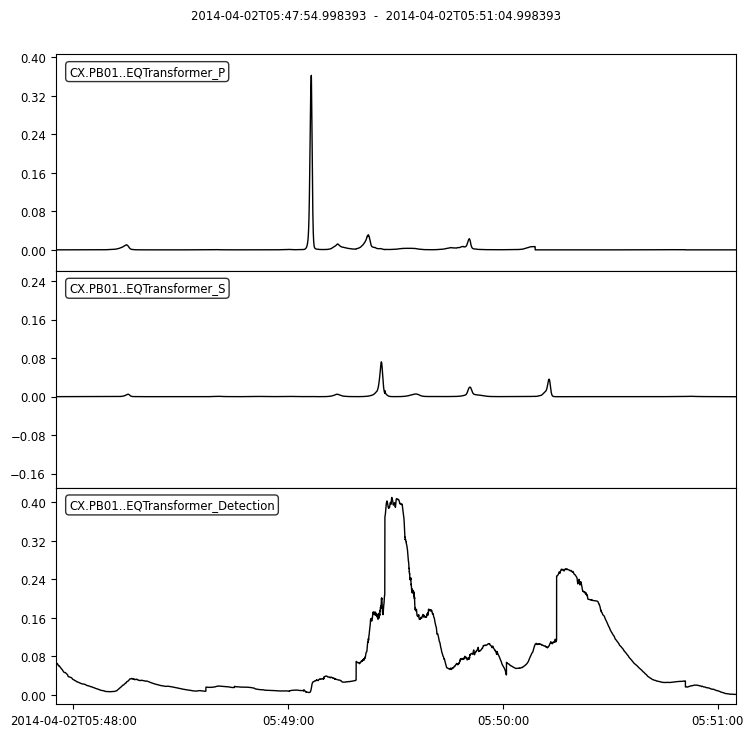

In [10]:
picker.annotate(stream).plot();

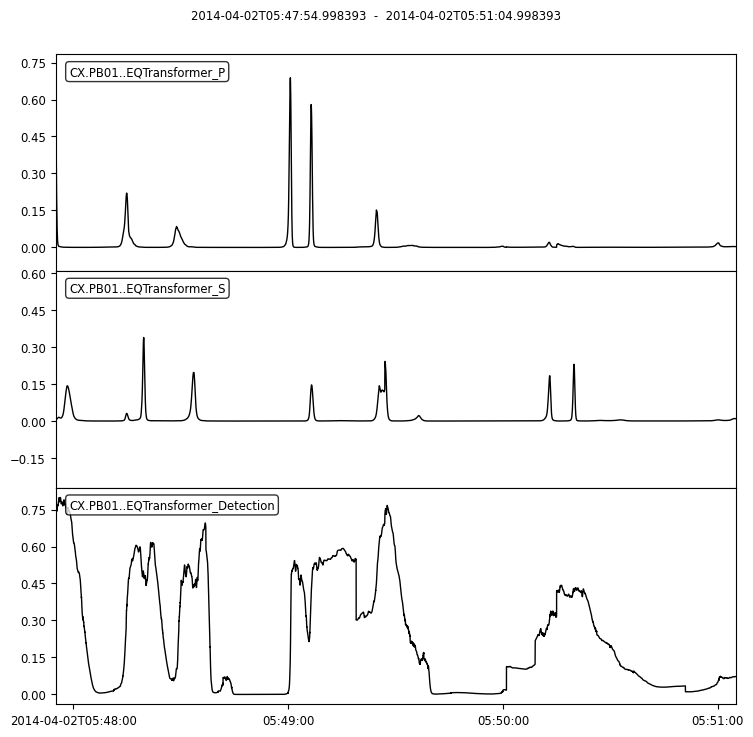

In [11]:
picker.annotate(annotations).plot();

The two plots show that EQTransformer is able to produce considerably better picks and detections when applied to the denoised data. It detects more events and has higher confidence scores.